In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import scipy

from livelossplot import PlotLosses


In [8]:
npdata = np.loadtxt("./dataset/sprase_train_2.txt") 
print("shape: ",npdata.shape)
npdata_test = np.loadtxt("./dataset/sprase_test_2.txt") 

shape:  (131098, 4499)


In [158]:
train_set = torch.FloatTensor(npdata)
test_set = torch.FloatTensor(npdata_test)

In [159]:
def toone(data_set):
    data_set[data_set == 0] = -1
    data_set[data_set == 1] = 0
    data_set[data_set == 2] = 0
    data_set[data_set >= 3] = 1
    return data_set

In [160]:
test_set = toone(test_set)
train_set = toone(train_set)

In [9]:

# # class RBM(nn.Module):
# class RBM():
#     def __init__(self,
#                  n_vis=4499,
#                  n_hin=100,
#                  k=5,
#                  use_gpu=False
#                 ):
# #         super(RBM, self).__init__()
#         self.desc = "RBM"
        
# #         self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
# #         self.v_bias = nn.Parameter(torch.zeros(1, n_vis))
# #         self.h_bias = nn.Parameter(torch.zeros(1 ,n_hin))

#         self.W = torch.randn(n_hin,n_vis)*1e-2
#         self.v_bias = torch.rand(1, n_vis)
#         self.h_bias = torch.rand(1 ,n_hin)
#         self.k = k
#         #self.myfunc = F.logsigmoid
    
        
#         self.use_gpu = use_gpu
#         if self.use_gpu:
#             self.W = self.W.cuda()
#             self.h_bias = self.h_bias.cuda()
#             self.v_bias = self.v_bias.cuda()
    
#     def v_to_h(self,v):
        
#         p_h =None
#         sample_h = None
# #         try:
#         #计算得到：1.s型激活函数的x值：w*v+hbia;2.隐藏层神经元为1的概率：P(h=1|v)
#         v_activation = F.linear(v,self.W,self.h_bias)
        
# #         wv = torch.mm(v, self.W.t())
# #         v_activation = wv + self.a.expand_as(wv)
        
#         p_h = F.softmax(v_activation,dim=1)
#         #采样隐藏层h的值
#         sample_h = torch.bernoulli(p_h)
# #         except:
# #             print("v",v)
# #             print("w",self.W)
# #             print("h",self.h_bias)
#         return p_h, sample_h
    
#     def h_to_v(self,h):
#         h_activation = F.linear(h,self.W.t(),self.v_bias)
# #         wh = torch.mm(h, self.W)
# #         h_activation = torch.mm(h, self.W) + self.b.expand_as(wh)
        
#         p_v = F.sigmoid(h_activation)
#         sample_v = torch.bernoulli(p_v)
#         return p_v, sample_v
        
#     def forward(self,v):
#         # do contrastive ydivergence
#         # Positive phase
#         pre_h1,_ = self.v_to_h(v)
#         # Negative phase; gibbs采样 
#         for k in range(self.k):
#             _,hk = self.v_to_h(v)
#             _,vk = self.h_to_v(hk)
#             # mask
#             vk[v <0] = v[v<0]
#         pre_hk,_ = self.v_to_h(vk)
#         return vk,pre_h1,pre_hk
    
#     def free_energy(self,v):
#         wx_b = F.linear(v, self.W, self.h_bias)
#         wx_b = (wx_b - wx_b.min()) / (wx_b.max() - wx_b.min())
#         # sum all hidden node :ln(1+exp(w*v+b))
#         hidden_term = wx_b.exp().add(1).log().sum(1)
#         #hidden_term = F.logsigmoid(data).add(1).sum(1)
#         vbias_term = v.mm(self.v_bias.t())
#         return (-hidden_term - vbias_term).mean()
    
# #     def test(self,v):
# #         pre_h1,h1 = self.v_to_h(v)
# #         h_ = h1
# #         pre_v_,v_ = self.h_to_v(h_)
# #         return v_
    
#     def train(self, v, vk, ph, phk):
#         # positive associations - negative associations
#         a = torch.matmul(v.t(), ph) - torch.matmul(vk.t(), phk)
#         self.W += a.t()
#         # input_data - negative_visible_probabilities
#         self.v_bias += torch.sum((v - vk), 0)
#         # positive_hidden_probabilities - negative_hidden_probabilities
#         self.h_bias += torch.sum((ph - phk), 0)


In [134]:
class RBM():
    def __init__(self,
                 n_vis=4499,
                 n_hin=100,
                 k=5,
                 state = "train",
                 use_gpu=False
                ):
        self.desc = "RBM"
        self.W = torch.randn(n_hin,n_vis)*1e-2
        self.v_bias = torch.rand(1, n_vis)
        self.h_bias = torch.rand(1 ,n_hin)
        self.k = k
        self.state = state
        self.use_gpu = use_gpu
        if self.use_gpu:
            self.W = self.W.cuda()
            self.h_bias = self.h_bias.cuda()
            self.v_bias = self.v_bias.cuda()
    
    def v_to_h(self,v):
        v_activation = F.linear(v,self.W,self.h_bias)
        p_h = F.softmax(v_activation,dim=1)
        sample_h = torch.bernoulli(p_h)
        return p_h, sample_h
    
    def h_to_v(self,h):
        h_activation = F.linear(h,self.W.t(),self.v_bias)
        p_v = F.sigmoid(h_activation)
        sample_v = torch.bernoulli(p_v)
        return p_v, sample_v
        
    def forward(self,v):
        # Positive phase
        pre_h1,_ = self.v_to_h(v)
        # Negative phase; gibbs
        for k in range(self.k):
            _,hk = self.v_to_h(v)
            _,vk = self.h_to_v(hk)
            if self.state =="train":
                # mask
                vk[v <0] = v[v<0]
        pre_hk,_ = self.v_to_h(vk)
        return vk,pre_h1,pre_hk
    
    def learn(self, v, vk, ph, phk):
        # positive associations - negative associations
        a = torch.matmul(v.t(), ph) - torch.matmul(vk.t(), phk)
        self.W += a.t()
        # input_data - negative_visible_probabilities
        self.v_bias += torch.sum((v - vk), 0)
        # positive_hidden_probabilities - negative_hidden_probabilities
        self.h_bias += torch.sum((ph - phk), 0)
    def train(self):
        self.state = "train"
    def val(self):
        self.state = "val"
    def save_model(self,dir_name):
        opt = {
            "W":self.W,
            "v_bias":self.v_bias,
            "h_bias":self.h_bias,
            "k":self.k
        }
        torch.save(opt,dir_name)
        pass
    def load_model(self,dir_name):
        opt = torch.load(dir_name)
        opt['W'] = self.W
        opt['v_bias'] = self.v_bias
        opt['h_bias'] = self.h_bias
        opt['k'] = self.k

    

In [169]:
liveloss = PlotLosses()
def RBM_ep(data_set):
    rbm.train()
    loss_ = []
    for i in range(0, npdata.shape[0] - batch_size-1, batch_size):
        print("i = ",i)
        data = data_set[i:i+batch_size]
        vk,pre_h1,pre_hk = rbm.forward(data)
        rbm.learn(data, vk, pre_h1, pre_hk)
        run_loss = torch.mean(torch.abs(data[data>=0] - vk[data>=0]))
        loss_.append(run_loss)
        
        liveloss.update({
            'cd':np.mean(loss_),
            'val_cd':run_loss
        })
        liveloss.draw()
        print("mean loss: ",np.mean(loss_))

In [153]:
def rmse(y_preds,y_actuals):
    tmse = sum([(a-b) * (a-b) for a,b in zip(y_preds, y_actuals)])
    rmse = math.sqrt((1.0*tmse)/len(y_preds))
    return rmse

In [154]:
# npdata = np.loadtxt("./dataset/np_matrix_1.txt") 
# print("shape: ",npdata.shape)

In [143]:
visible_num = npdata.shape[1]
hidden_num = 10
# rbm = RBM(k=k,n_vis = visible_num, n_hin=hidden_num)

In [145]:
batch_size = 1024
k = 1
lr = 0.0003
# train_op = optim.SGD(rbm.parameters(),lr)

In [161]:
train_set

tensor([[ 1., -1., -1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

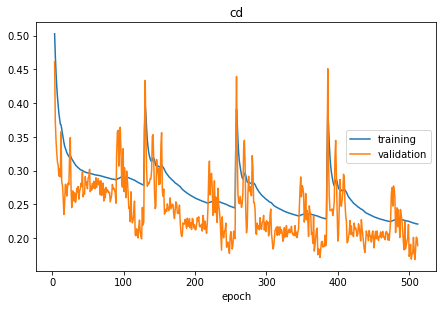

cd:
training   (min:    0.221, max:    0.542, cur:    0.221)
validation (min:    0.168, max:    0.542, cur:    0.189)
mean loss:  0.2207973


In [165]:
RBM_ep(train_set)

In [171]:
rbm.val()
vk,pre_h1,pre_hk = rbm.forward(train_set[55:66])


In [172]:
train_set[55:66]

tensor([[ 1., -1., -1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [ 0.,  0.,  0.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.]])

In [173]:
vk

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [166]:
rbm.save_model('./dataset/rbm1.tar')

In [133]:
# rbm.load_model('./dataset/rbm1.tar')

In [91]:
# for epoch in range(10):
#     loss_ = []
#     for i in range(0, npdata.shape[0] - batch_size-1, batch_size):
#         print("i = ",i)
#         data = Variable(torch.from_numpy(npdata[i:i+batch_size]).type('torch.FloatTensor'))
#         vk,pre_h1,pre_hk = rbm.forward(data)
        
# #         # loss = 所有用户的自由能F(v)的均值的差; 
#         loss = rbm.free_energy(data)- rbm.free_energy(vk)
#         print("energy loss: ",loss)
# #         if(loss<0):
# #             print("loss",loss)
# # #             print(data[data>0])
# #             a = vk.t().max(1, keepdim=True)[0]
# #             print(a[a>1])
            
# #             break
        
# #         loss_.append(loss.data[0])
# #         train_op.zero_grad()
# #         loss.backward()
# #         train_op.step()
#         rbm.train(data, vk, pre_h1, pre_hk)
    
#         loss_.append(torch.mean(torch.abs(data[data>=0] - vk[data>=0])))

#         print("mean loss: ",np.mean(loss_))

In [21]:
data = Variable(torch.from_numpy(npdata[1:11]).type('torch.FloatTensor'))
# vk,pre_h1,pre_hk = rbm(data) 
vk,pre_h1,pre_hk = rbm.forward(data)
a = vk.t().max(1, keepdim=True)[1].data.t()
print(data)
print(vk)
# print(a[data[1]>0])
# print(len(a[a>0]))

tensor([[3., 0., 0.,  ..., 0., 0., 0.],
        [3., 0., 0.,  ..., 0., 0., 0.],
        [5., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [4., 0., 0.,  ..., 0., 0., 0.],
        [5., 0., 0.,  ..., 0., 0., 0.],
        [3., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [23]:
data[data>0]

tensor([3., 1., 4.,  ..., 4., 1., 4.])

In [24]:
vk[vk>0]

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [25]:
class RBM2():
    def __init__(self, nv, nh):
        self.W = torch.randn(nv, nh)
        self.a = torch.randn(nv)
        self.b = torch.randn(nh)

    def sample_h(self, x):
        activation = torch.matmul(x, self.W) + self.b
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        activation = torch.matmul(y, self.W.t()) + self.a
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def train(self, v0, vk, ph0, phk):
        self.W += torch.matmul(v0.t(), ph0) - torch.matmul(vk.t(), phk)
        self.a += torch.sum((v0 - vk), 0)
        self.b += torch.sum((ph0 - phk), 0)

In [35]:
nv = 4499
nh = 100
batch_size = 100
nb_users = npdata.shape[0]
rbm2 = RBM2(nv, nh)

In [36]:
npdata.shape

(131098, 4499)

In [62]:
liveloss = PlotLosses()
def epoch_rbm2():
    train_loss = 0
    s = 0.0
    for id_user in range (0, nb_users - batch_size, batch_size):
        vk = train_set[id_user:id_user+batch_size]
        vo = train_set[id_user:id_user+batch_size]
        pho,_ = rbm2.sample_h(vo)
        for k in range (10):
            _,hk = rbm2.sample_h(vk)
            _,vk = rbm2.sample_v(hk)
            vk[vo<0] = vk[vo<0]
            if len(vk[vo<0])>0:
                print(vk[vo<0] )
        phk,_ = rbm2.sample_h(vk)
        rbm2.train(vo,vk,pho,phk)
        cd = torch.mean(torch.abs(vo[vo>=0] - vk[vo>=0]))
        train_loss += cd
        s += 1.0
        
        liveloss.update({
            'cd':train_loss/s,
            'val_cd':cd
        })
        liveloss.draw()
    return (train_loss/s)

In [64]:
epoch_rbm2()

KeyboardInterrupt: 

In [68]:
# Testing the RBM
test_loss = 0
s = 0.
for id_user in range(nb_users):
    v = train_set[id_user:id_user+1]
    vt = test_set[id_user:id_user+1]
    if len(vt[vt>=0]) > 0:
        _,h = rbm2.sample_h(v)
        _,v = rbm2.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.1703)


In [76]:
_,h = rbm2.sample_h(test_set[:100]) 
_,v = rbm2.sample_v(h)
print(v)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [85]:
_.shape

torch.Size([100, 4499])

In [87]:
_[0][_[0]>0]

tensor([1.0000e+00, 1.2438e-13, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 3.1731e-20, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        8.5518e-31, 1.0000e+00, 1.0000e+00, 1.0000e+00, 7.1295e-32, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 5.7181e-35, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+